In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Install libs

In [2]:
!pip install imutils > /dev/null
!pip install cython > /dev/null
# Install pycocotools from this GitHub rep
!pip install git+"https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI" > /dev/null

  Running command git clone -q https://github.com/philferriere/cocoapi.git /tmp/pip-req-build-xdqentdv


In [3]:
TOP_PATH = ('/kaggle/input/coco-2017-dataset/coco2017')
TRAIN_PATH = ('/kaggle/input/coco-2017-dataset/coco2017/train2017')
VAL_PATH = ('/kaggle/input/coco-2017-dataset/coco2017/val2017')
ANNOTATIONS_PATH = ('/kaggle/input/coco-2017-dataset/coco2017/annotations')
TEST_PATH = ('/kaggle/input/coco-2017-dataset/coco2017/test2017')
WORKING_DIR = ('/kaggle/working')
MASK_TRAIN_DIR = ('/kaggle/working/mask_train')
MASK_VAL_DIR =('/kaggle/working/mask_val')
MASK_TRAIN_SMOOTH_DIR = ('/kaggle/working/mask_train_smooth')

In [4]:
os.chdir(WORKING_DIR)

# Import Libraries

In [5]:
# Import all the libraries
import numpy as np
import cv2
import requests
import os
import imutils
from PIL import Image
from tqdm.notebook import tqdm
########3
from pycocotools import coco, cocoeval, _mask
from pycocotools import mask as maskUtils
from pycocotools.coco import COCO
import skimage.io as io
import random
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from random import shuffle

from PIL import Image 
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *

# Load the TensorBoard notebook extension.

%load_ext tensorboard


from datetime import datetime

seed = 2019

random.seed = seed
np.random.seed = seed

2021-09-17 21:01:22.785801: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Dataset Processing

In [6]:
os.listdir(ANNOTATIONS_PATH)

['person_keypoints_train2017.json',
 'instances_val2017.json',
 'instances_train2017.json',
 'person_keypoints_val2017.json',
 'captions_train2017.json',
 'captions_val2017.json']

In [7]:
ANNOTATION_FILE_VAL = (ANNOTATIONS_PATH + '/instances_val2017.json')
ANNOTATION_FILE_TRAIN = (ANNOTATIONS_PATH + '/instances_train2017.json')

In [8]:
coco_train = COCO(ANNOTATION_FILE_TRAIN)
catIds_train = coco_train.getCatIds()
imgIds_train = coco_train.getImgIds()
imgDict_train = coco_train.loadImgs(imgIds_train)
print(len(imgIds_train) , len(catIds_train))

loading annotations into memory...
Done (t=24.96s)
creating index...
index created!
118287 80


In [9]:
coco_val = COCO(ANNOTATION_FILE_VAL)
catIds_val = coco_val.getCatIds()
imgIds_val = coco_val.getImgIds()
imgDict_val = coco_val.loadImgs(imgIds_val)
print(len(imgIds_val) , len(catIds_val))

loading annotations into memory...
Done (t=1.33s)
creating index...
index created!
5000 80


In [10]:
shuffle(imgIds_train)
shuffle(imgIds_val)

#take less samples
imgIds_train = imgIds_train[0:60000]
imgIds_val = imgIds_val[0:5000]
# imgIds_train = imgIds_train[0:3000]
# imgIds_val = imgIds_val[0:500]


In [11]:
train_images = ["COCO_train2014_{0:012d}.jpg".format(ids) for ids in imgIds_train]
val_images = ["COCO_val2014_{0:012d}.jpg".format(ids) for ids in imgIds_val]
print(len(train_images) , len(val_images))

60000 5000


In [12]:
os.chdir(WORKING_DIR)

In [13]:
!mkdir mask_train

In [14]:
count = 0 
unfitted_image_dict = []
for ID in tqdm(imgIds_train):
    file_path = MASK_TRAIN_DIR+"/{0:012d}.jpg".format(ID)

    sampleImgIds = coco_train.getImgIds(imgIds = [ID])
    sampleImgDict = coco_train.loadImgs(sampleImgIds[np.random.randint(0,len(sampleImgIds))])[0]

    annIds = coco_train.getAnnIds(imgIds=sampleImgDict['id'], 
                                catIds=catIds_train, 
                                iscrowd=0)
    anns = coco_train.loadAnns(annIds)

    if len(anns)==0:
        unfitted_image_dict.append(sampleImgDict)
    else:
        mask = coco_train.annToMask(anns[0])

        for i in (range(len(anns))):
            mask = mask | coco_train.annToMask(anns[i])
        mask = Image.fromarray(mask * 255 , mode = "L")
        mask.save(file_path)
        count = count + 1
print(count)

  0%|          | 0/60000 [00:00<?, ?it/s]

59495


In [15]:
os.chdir(WORKING_DIR)

In [16]:
!mkdir mask_val

In [17]:
count = 0 
unfitted_image_dict = []
for ID in tqdm(imgIds_val):
    file_path = MASK_VAL_DIR+"/{0:012d}.jpg".format(ID)

    sampleImgIds = coco_val.getImgIds(imgIds = [ID])
    sampleImgDict = coco_val.loadImgs(sampleImgIds[np.random.randint(0,len(sampleImgIds))])[0]

    annIds = coco_val.getAnnIds(imgIds=sampleImgDict['id'], 
                                catIds=catIds_val, 
                                iscrowd=0)
    anns = coco_val.loadAnns(annIds)

    if len(anns)==0:
        unfitted_image_dict.append(sampleImgDict)
    else:
        mask = coco_val.annToMask(anns[0])

        for i in (range(len(anns))):
            mask = mask | coco_val.annToMask(anns[i])
        mask = Image.fromarray(mask * 255 , mode = "L")
        mask.save(file_path)
        count = count + 1
print(count)

  0%|          | 0/5000 [00:00<?, ?it/s]

4952


In [18]:
os.chdir(WORKING_DIR)

# Data Loader

In [19]:
class DataGen(keras.utils.Sequence):
    def __init__(self , path_input , path_mask , batch_size = 8 , image_size = 128):
        self.ids = os.listdir(path_mask) # only take those images that we have segregated masks of
        self.path_input = path_input
        self.path_mask = path_mask
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self , id_name):
        image_path = os.path.join(self.path_input , id_name)
        mask_path = os.path.join(self.path_mask , id_name)
        image = cv2.imread(image_path , 1) # 1 specifies RGB format
        image = cv2.resize(image , (self.image_size , self.image_size)) # resizing before inserting to the network
        mask = cv2.imread(mask_path , -1)
        mask = cv2.resize(mask , (self.image_size , self.image_size))
        mask = mask.reshape((self.image_size , self.image_size , 1))
        #normalize image
        image = image / 255.0
        mask = mask / 255.0
        return image , mask
    
    def __getitem__(self , index):
        if (index + 1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size
        file_batch = self.ids[index * self.batch_size : (index + 1) * self.batch_size]
        images = []
        masks = []
        
        for id_name in file_batch : 
            _img , _mask = self.__load__(id_name)
            images.append(_img)
            masks.append(_mask)
        
        images = np.array(images)
        masks = np.array(masks)
        return images , masks
    
    def on_epoch_end(self):
        pass
    def __len__(self):
        return int(np.ceil(len(self.ids) / float(self.batch_size)))

In [20]:
image_size = 128 
epochs = 20
batch_size = 5

In [21]:
train_gen = DataGen(path_input = TRAIN_PATH , path_mask = MASK_TRAIN_DIR , batch_size = batch_size , image_size = image_size)
val_gen = DataGen(path_input =  VAL_PATH, path_mask =  MASK_VAL_DIR, batch_size = batch_size , image_size = image_size)

In [22]:
x, y = val_gen.__getitem__(4)

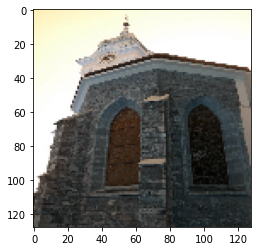

In [23]:
plt.imshow(x[0]) # just an example to show that the dataloader is working fine

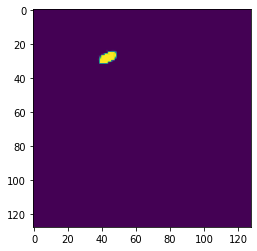

In [24]:
plt.imshow(y[0])

# Define U-Net and Train the model

In [25]:
# def crop_img(tensor,target_tensor):
#     target_size = target_tensor.shape[2]
#     tensor_size = tensor.shape[2]
#     delta = tensor_size-target_size
#     delta = delta//2 
#     return tensor[:,delta:tensor_size-delta,delta:tensor_size-delta,:]

In [26]:
# U-Net Actual Architecture

image_size = 128
h = image_size
w = image_size
channels = 3

# input area
model_in = Input(shape=(h, w, channels))


# down convolutions
conv1 = BatchNormalization(scale=True)(model_in)
conv1 = Conv2D(64, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(conv1)
conv1 = Conv2D(64, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(conv1)
down1 = MaxPooling2D((2, 2), strides=2)(conv1)

conv2 = BatchNormalization(scale=True)(down1)
conv2 = Conv2D(128, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(conv2)
conv2 = Conv2D(128, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(conv2)
down2 = MaxPooling2D((2, 2), strides=2)(conv2)

conv3 = BatchNormalization(scale=True)(down2)
conv3 = Conv2D(256, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(conv3)
conv3 = Conv2D(256, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(conv3)
down3 = MaxPooling2D((2, 2), strides=2)(conv3)

conv4 = BatchNormalization(scale=True)(down3)
conv4 = Conv2D(512, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(conv4)
conv4 = Conv2D(512, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(conv4)
down4 = MaxPooling2D((2, 2), strides=2)(conv4)

# bottleneck region 
conv5 = BatchNormalization(scale=True)(down4)
conv5 = Conv2D(1024, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(conv5)
conv5 = Conv2D(1024, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(conv5)



# up convolutions
conv6 = BatchNormalization(scale=True)(conv5)
conv6 = Conv2DTranspose(512, (2, 2), activation='relu',strides=(2,2),kernel_initializer="he_normal", padding="same")(conv6)
#crop1 = crop_img(conv4,conv6)
concat1 = concatenate([conv4, conv6], axis=3)
conv6 = Conv2D(512, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(concat1)
conv6 = Conv2D(512, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(conv6)

conv7 = BatchNormalization(scale=True)(conv6)
conv7 = Conv2DTranspose(256, (2, 2), activation='relu',strides=2,kernel_initializer="he_normal", padding="same")(conv7)
#crop2 = crop_img(conv3,conv7)
concat2 = concatenate([conv3, conv7], axis=3)
conv7 = Conv2D(256, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(concat2)
conv7 = Conv2D(256, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(conv7)

conv8 = BatchNormalization(scale=True)(conv7)
conv8 = Conv2DTranspose(128, (2, 2), activation='relu',strides=2,kernel_initializer="he_normal", padding="same")(conv8)
#crop3 = crop_img(conv2,conv8)
concat3 = concatenate([conv2, conv8], axis=3)
conv8 = Conv2D(128, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(concat3)
conv8 = Conv2D(128, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(conv8)

conv9 = BatchNormalization(scale=True)(conv8)
conv9 = Conv2DTranspose(128, (2, 2), activation='relu',strides=2,kernel_initializer="he_normal", padding="same")(conv9)
#crop4 = crop_img(conv1,conv9)
concat4 = concatenate([conv1, conv9], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(concat4)
conv9 = Conv2D(64, (3, 3), activation='relu',kernel_initializer="he_normal", padding="same")(conv9)

# final 1x1 convolution 
conv10 = Conv2D(1,kernel_size=(1,1),activation="sigmoid",kernel_initializer="he_normal", padding="same")(conv9)

model = Model(model_in, conv10)

2021-09-17 21:08:39.628376: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-17 21:08:39.632169: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-17 21:08:39.669322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-17 21:08:39.670074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-17 21:08:39.670159: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-17 21:08:39.714231: I tensorflow/stream_executor/platform/def

In [27]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
# model.compile(optimizer = SGD(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy',MeanIoU(num_classes=2)])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
______________________________________________________________________________________________

In [29]:
train_steps =  len(os.listdir(MASK_TRAIN_DIR))/batch_size
logdir = WORKING_DIR+"/logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir) 
model.fit_generator(train_gen , validation_data = val_gen , steps_per_epoch = train_steps , epochs=epochs, callbacks=[tensorboard_callback])

2021-09-17 21:08:42.286112: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-17 21:08:42.286163: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-17 21:08:42.287000: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2021-09-17 21:08:42.305437: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.11.0
2021-09-17 21:08:42.494572: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-17 21:08:42.494794: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and 

Epoch 1/20


2021-09-17 21:08:44.740287: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-09-17 21:08:50.127253: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-17 21:08:50.892650: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


    2/11899 [..............................] - ETA: 1:21:43 - loss: 0.7723 - accuracy: 0.4318 

2021-09-17 21:08:52.300663: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-17 21:08:52.300719: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


    3/11899 [..............................] - ETA: 1:16:36 - loss: 0.7575 - accuracy: 0.4531

2021-09-17 21:08:52.665307: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-09-17 21:08:52.665940: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2021-09-17 21:08:52.803038: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 523 callback api events and 511 activity events. 
2021-09-17 21:08:52.817298: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-17 21:08:52.836553: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /kaggle/working/logs/scalars/20210917-210842/train/plugins/profile/2021_09_17_21_08_52
2021-09-17 21:08:52.846907: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /kaggle/working/logs/scalars/20210917-210842/train/plugins/profile/2021_09_17_21_08_52/1c6231d6a5b2.trace.json.gz
2021-09-17 21:08:52.878631: I tensorflow/co

11899/11899 [==============================] - 1338s 112ms/step - loss: 0.4639 - accuracy: 0.7465 - val_loss: 0.3875 - val_accuracy: 0.7874
Epoch 2/20
11899/11899 [==============================] - 977s 82ms/step - loss: 0.3739 - accuracy: 0.7974 - val_loss: 0.3676 - val_accuracy: 0.7920
Epoch 3/20
11899/11899 [==============================] - 960s 81ms/step - loss: 0.3405 - accuracy: 0.8133 - val_loss: 0.3390 - val_accuracy: 0.8124
Epoch 4/20
11899/11899 [==============================] - 963s 81ms/step - loss: 0.3119 - accuracy: 0.8274 - val_loss: 0.3315 - val_accuracy: 0.8157
Epoch 5/20
11899/11899 [==============================] - 1002s 84ms/step - loss: 0.2846 - accuracy: 0.8412 - val_loss: 0.3367 - val_accuracy: 0.8148
Epoch 6/20
11899/11899 [==============================] - 977s 82ms/step - loss: 0.2541 - accuracy: 0.8569 - val_loss: 0.3348 - val_accuracy: 0.8141
Epoch 7/20
11899/11899 [==============================] - 937s 79ms/step - loss: 0.2240 - accuracy: 0.8720 - val_l

In [30]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip 
! yes |unzip ngrok-stable-linux-amd64.zip

# LOG_DIR = 'tb_folder/log/' 
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(logdir)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2021-09-18 02:43:03--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.237.133.81, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  14.4MB/s    in 0.9s    

2021-09-18 02:43:05 (14.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
yes: standard output: Broken pipe
curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
https://9cd4-35-233-203-44.ngrok.io


(2, 128, 128, 3)
(2, 128, 128, 1)
(128, 128, 1)


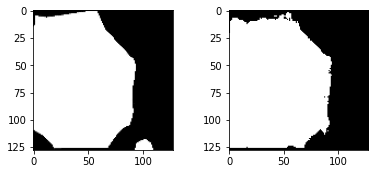

In [31]:
x, y = val_gen.__getitem__(1)
print(x.shape)
result = model.predict(x)
print(result.shape)
print(y[0].shape)

result = result > 0.5

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")